**Load and Explore the Dataset**

In [1]:
import pandas as pd

# Load Parquet dataset
file_path = "/kaggle/input/nfunswnb15v2/NF-UNSW-NB15-V2.parquet"
df = pd.read_parquet(file_path)

# Check structure
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986745 entries, 0 to 1986744
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int32  
 1   L4_DST_PORT                  int32  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int16  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int16  
 8   TCP_FLAGS                    int8   
 9   CLIENT_TCP_FLAGS             int8   
 10  SERVER_TCP_FLAGS             int8   
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int16  
 13  DURATION_OUT                 int16  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int16  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  

#  Preprocess the Data

**Handle Missing Values**

In [2]:
# Check for missing values
print(df.isnull().sum())

# Fill or drop missing values
df.ffill(inplace=True)  # Forward fill
# OR
df.dropna(inplace=True)  # Drop rows with missing values


L4_SRC_PORT                    0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_128_TO_256_BYTES      0
NUM_PKTS_2

**Convert Categorical Features to Numeric**

In [3]:
# Check unique values in "Attack" column
print("Unique values in 'Attack':", df["Attack"].unique())

# Check unique values in "Label" column
print("Unique values in 'Label':", df["Label"].unique())

# Count occurrences of each value
print("\nAttack Column Value Counts:\n", df["Attack"].value_counts())
print("\nLabel Column Value Counts:\n", df["Label"].value_counts())


Unique values in 'Attack': ['Benign' 'Exploits' 'Generic' 'Fuzzers' 'Backdoor' 'DoS' 'Reconnaissance'
 'Shellcode' 'Worms' 'Analysis']
Unique values in 'Label': [0 1]

Attack Column Value Counts:
 Attack
Benign            1911666
Exploits            29905
Fuzzers             20645
Reconnaissance      11171
Generic              5992
DoS                  4172
Shellcode            1427
Backdoor              833
Analysis              770
Worms                 164
Name: count, dtype: int64

Label Column Value Counts:
 Label
0    1911666
1      75079
Name: count, dtype: int64


**We'll encode the "Attack" column using Label Encoding so that each attack type gets a unique number.**

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the "Attack" column
df["Attack_Encoded"] = le.fit_transform(df["Attack"])

# Show the mapping of attack names to numbers
attack_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Attack Type Encoding:", attack_mapping)

# Drop the original "Attack" column (optional)
df.drop(columns=["Attack"], inplace=True)

# Display the first few rows to verify
df.head()


Attack Type Encoding: {'Analysis': 0, 'Backdoor': 1, 'Benign': 2, 'DoS': 3, 'Exploits': 4, 'Fuzzers': 5, 'Generic': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack_Encoded
0,1305,21,6,1.0,9,1,193,3,24,24,...,0,7240,0,0,0,0,0,331.0,0,2
1,1305,21,6,1.0,261,5,469,7,24,24,...,8688,8688,18944,74,0,0,0,230.0,0,2
2,1305,21,6,1.0,481,9,750,11,24,24,...,10136,10136,33792,132,0,0,0,229.0,0,2
3,1305,21,6,1.0,701,13,1054,15,24,24,...,11584,11584,48640,190,0,0,0,125.0,0,2
4,1305,21,6,1.0,1031,19,1474,21,24,24,...,14480,13032,64256,251,0,0,0,230.0,0,2


 **Normalize Numerical Features**
* Since the dataset contains different scales (packet sizes, byte counts, time durations), normalizing the features will improve model performance.

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns (excluding 'Label')
num_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float32']).columns
num_cols = [col for col in num_cols if col not in ["Label", "Attack_Encoded"]]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Display the first few rows
df.head()


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack_Encoded
0,0.019913,0.00032,0.023529,0.004032,2.645379e-07,0.000000,0.000013,0.000271,24,24,...,0.000000,0.110482,0.000000,0.000000,0.0,0.0,0.0,0.660679,0,2
1,0.019913,0.00032,0.023529,0.004032,8.597483e-06,0.000175,0.000032,0.000632,24,24,...,0.132574,0.132578,0.290032,0.290196,0.0,0.0,0.0,0.459082,0,2
2,0.019913,0.00032,0.023529,0.004032,1.587228e-05,0.000349,0.000051,0.000993,24,24,...,0.154670,0.154675,0.517354,0.517647,0.0,0.0,0.0,0.457086,0,2
3,0.019913,0.00032,0.023529,0.004032,2.314707e-05,0.000524,0.000072,0.001354,24,24,...,0.176766,0.176771,0.744676,0.745098,0.0,0.0,0.0,0.249501,0,2
4,0.019913,0.00032,0.023529,0.004032,3.405926e-05,0.000786,0.000101,0.001896,24,24,...,0.220957,0.198868,0.983756,0.984314,0.0,0.0,0.0,0.459082,0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986745 entries, 0 to 1986744
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  float64
 1   L4_DST_PORT                  float64
 2   PROTOCOL                     float64
 3   L7_PROTO                     float64
 4   IN_BYTES                     float64
 5   IN_PKTS                      float64
 6   OUT_BYTES                    float64
 7   OUT_PKTS                     float64
 8   TCP_FLAGS                    int8   
 9   CLIENT_TCP_FLAGS             int8   
 10  SERVER_TCP_FLAGS             int8   
 11  FLOW_DURATION_MILLISECONDS   float64
 12  DURATION_IN                  float64
 13  DURATION_OUT                 float64
 14  MIN_TTL                      float64
 15  MAX_TTL                      float64
 16  LONGEST_FLOW_PKT             float64
 17  SHORTEST_FLOW_PKT            float64
 18  MIN_IP_PKT_LEN               float64
 19  

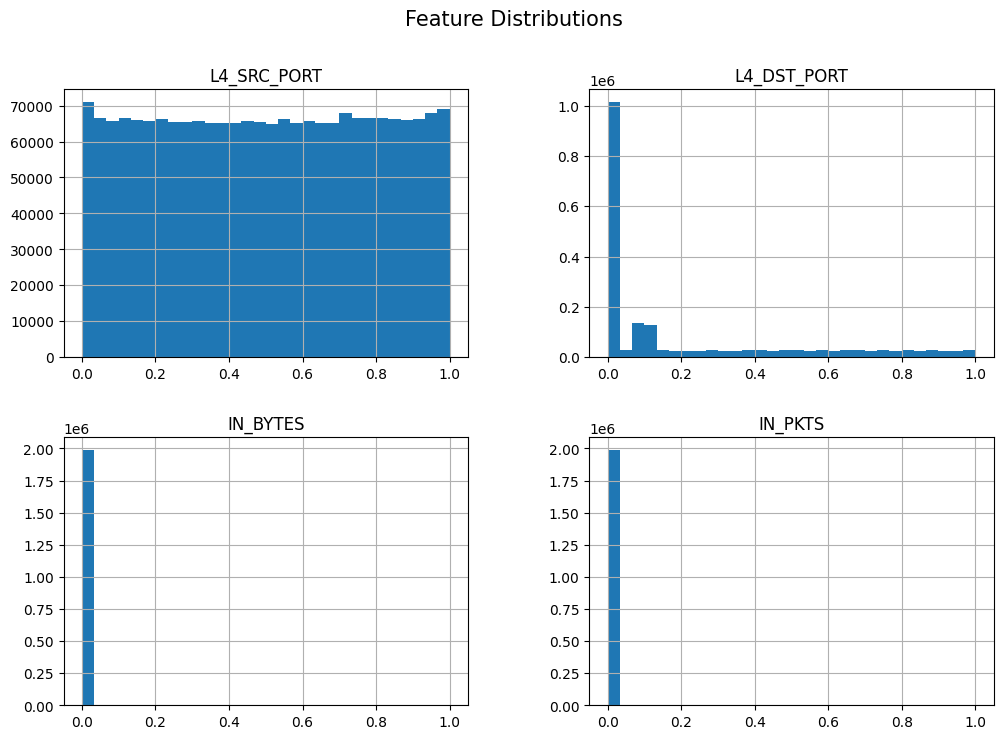

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming 'df' is already loaded)
print(df.info())  # Dataset overview
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Check for missing values

# Select numerical features for analysis
num_features = ["L4_SRC_PORT", "L4_DST_PORT", "IN_BYTES", "IN_PKTS"]

# Plot histograms
df[num_features].hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=15)
plt.show()



In [7]:
# Fix feature selection based on actual dataset
selected_features = [
    "L4_SRC_PORT",  # Source Port
    "L4_DST_PORT",  # Destination Port
    "PROTOCOL",     # Protocol Type
    "IN_BYTES",     # Total Bytes (Incoming)
    "IN_PKTS"       # Total Packets (Incoming)
]

# Define input (X) and output (y)
X = df[selected_features]  # Use the correct feature names
y = df["Label"]  # Change to "Attack" if needed

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (1589396, 5)
Testing set size: (397349, 5)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9942972047243104
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    382307
           1       0.91      0.94      0.93     15042

    accuracy                           0.99    397349
   macro avg       0.95      0.97      0.96    397349
weighted avg       0.99      0.99      0.99    397349



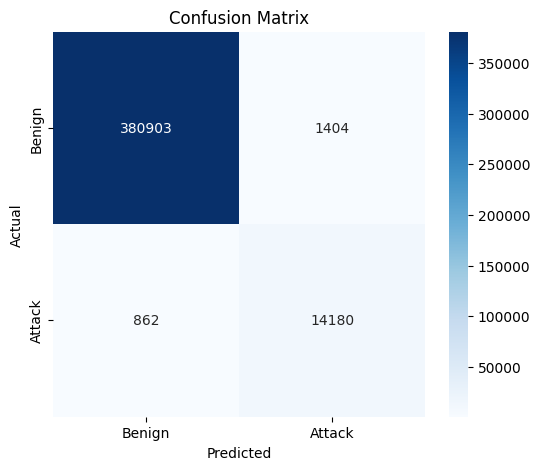

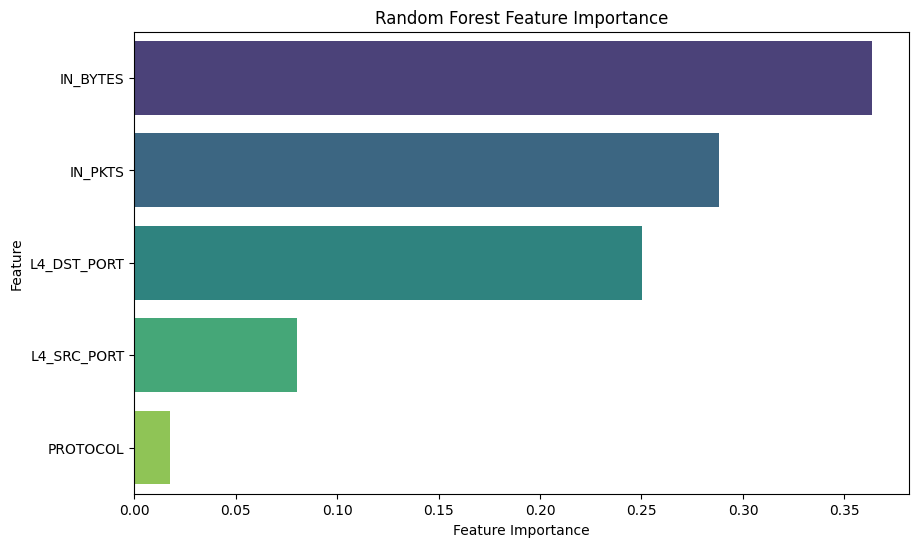

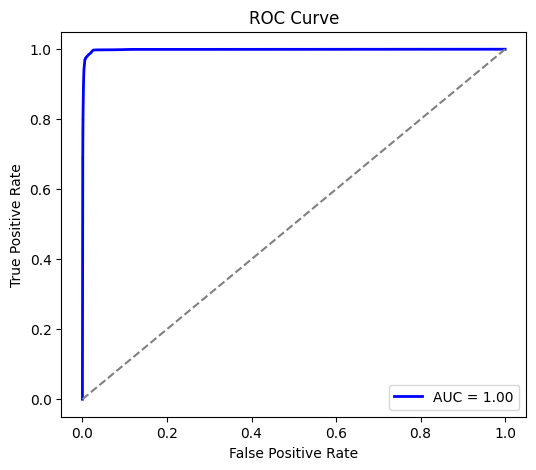

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 2️⃣ Feature Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=feature_names[sorted_indices], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

# 3️⃣ ROC Curve
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probability scores for class 1
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
